# ACTL3143 Assignment: Sentiment Analysis Using Deep Learning

By Sharon Zhou (z5310019)

## Table of contents
* [Introduction](#introduction)
* [Data Preparation](#datapreparation)
* [Exploratory Data Analysis](#eda)
* [Data Preprocessing](#datapreprocessing)
* [Benchmark Model: Logistic Regression](#benchmarkmodel)
* [Deep Learning Model 1: RNN](#RNN)
* [Deep Learning Model 1: LTSM](#LSTM)
* [Discussion](#discussion)

## 1. Introduction <a class="anchor" id="introduction"></a>

This assignment will use a database of tweets about companies fed through Natural Language Processing (NLP) techniques into supervised machine learning models that can classify the sentiment of a Twitter message. This is a ternary classification type problem with a "goal" field of Positive, Negative or Neutral. 

We will first conduct exploratory data analysis to gain insights into the dataset. A logistic regression model will then be fitted as a baseline to assess the performance of two deep learning models – the recurrent neural network (RNN) and the long short-term memory (LSTM) network.

### 1.1 Data Dictionary 

Information on the attributes in the dataset is contained below: 

* ``` id ```: the Tweet's ID
* ``` entity ```: the company the Tweet is referring to
* ``` sentiment ```: the polarity of the Tweet (Positive, Negative, Neutral). 
* ``` tweet ```: the contents of the Tweet 

## 2. Data Preparation <a class="anchor" id="datapreparation"></a>

### 2.1 Loading all packages 

In [3]:
from pathlib import Path
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random

from sklearn import set_config, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV, KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import uniform, randint

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, LSTM, RNN, Dropout, Dense, Embedding, Reshape, Concatenate, Input, SpatialDropout1D, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

from wordcloud import WordCloud
import emoji
import regex as re
from tqdm import tqdm
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sharo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sharo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2.2 Importing data 

The dataset used is an entity-level Twitter Sentiment Analysis dataset that contains 74,682 training tweets and 1,000 validation tweets. The dataset was downloaded from the following website:
https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [4]:
#Importing the dataset

response = requests.get("https://raw.githubusercontent.com/sharonnnzhou/actl3143/main/assignment/twitter_training.csv")

if response.status_code == 200:
    with open("twitter_training.csv", "wb") as file:
        file.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print("Error downloading the dataset.")
    
df_training = pd.read_csv("twitter_training.csv", header=None)

response2 = requests.get("https://raw.githubusercontent.com/sharonnnzhou/actl3143/main/assignment/twitter_validation.csv")

if response2.status_code == 200:
    with open("twitter_validation.csv", "wb") as file:
        file.write(response2.content)
    print("Dataset downloaded successfully.")
else:
    print("Error downloading the dataset.")

df_validation = pd.read_csv("twitter_validation.csv", header=None)

Dataset downloaded successfully.
Dataset downloaded successfully.


In [5]:
df_training.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df_validation.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


### 2.3 Formatting data

To format our data for input into the model, we will first create column names to replace the empty headers in the dataset.

In [7]:
#Applying column names 

col_names = ['id','entity','sentiment','tweet']

df_training.columns= col_names
df_validation.columns= col_names

We then check for null values and column types in the dataset. It can be seen that there exist 686 rows in the training dataset with NULL values for the "tweet" column. Therefore, we remove these rows.

In [8]:
#Information about data

df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
#Changing column type of "tweet" to string

df_training["tweet"]=df_training["tweet"].astype("string")
df_validation["tweet"]=df_validation["tweet"].astype("string")

In [10]:
#Checking for null entries

df_training.isnull().sum()

id             0
entity         0
sentiment      0
tweet        686
dtype: int64

In [11]:
df_validation.isnull().sum()

id           0
entity       0
sentiment    0
tweet        0
dtype: int64

In [12]:
df_training.dropna(inplace=True, axis=0)
df_training.isnull().sum()

id           0
entity       0
sentiment    0
tweet        0
dtype: int64

In [13]:
#Checking and dropping duplicate entries

df_training.duplicated().sum()

2340

In [14]:
df_validation.duplicated().sum()

0

In [15]:
df_training.drop_duplicates(inplace=True)

Tweets that are "Irrelevant" are also regarded as "Neutral", so we change those accordingly.

In [16]:
#Changing Irrelevant tweets to Neutral tweets

df_training['sentiment'] = df_training['sentiment'].replace(['Irrelevant'], ['Neutral'])
df_validation['sentiment'] = df_validation['sentiment'].replace(['Irrelevant'], ['Neutral'])

Finally, we check for any potential dataset imbalances in the target category. Given that the three classes are roughly similar, there is minimal dataset imbalance and no need for resampling.

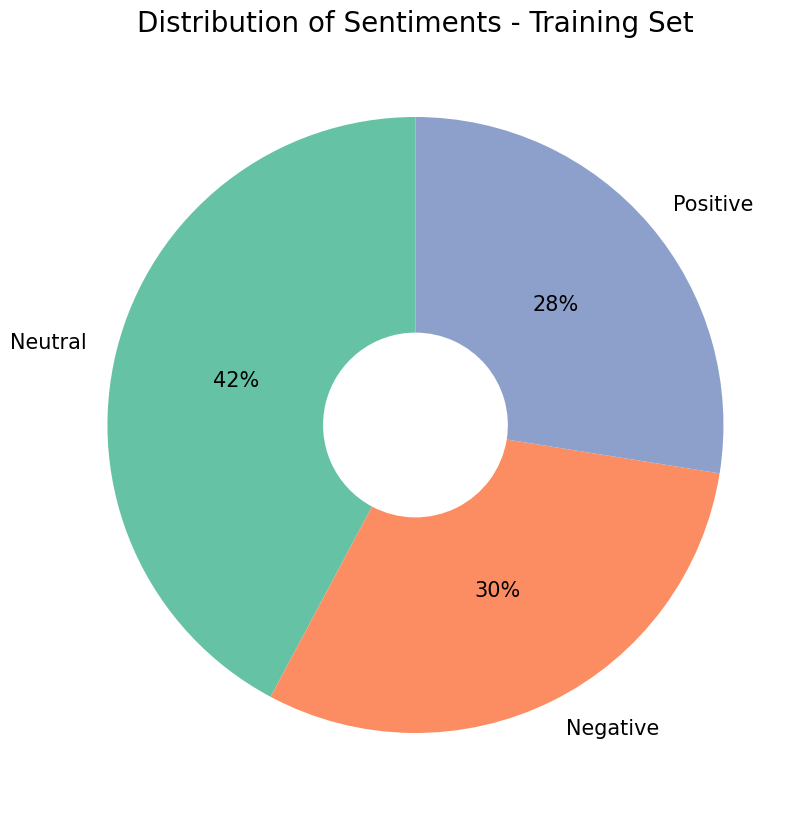

In [17]:
#Checking for data imbalances

plt.figure(figsize=(15, 10))
plt.title('Distribution of Sentiments - Training Set', fontsize=20)
df_training["sentiment"].value_counts().plot(kind='pie', wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle=90,
                                             textprops={'fontsize': 15}, colors = sns.color_palette('Set2'))

plt.ylabel('') 

plt.show()

## 3. Exploratory Data Analysis <a class="anchor" id="eda"></a>

### 3.1 Word and Letter Count 


This section looks at whether word count and the number of letters in a Tweet have a relationship to the overall sentiment of the Tweet.

In [18]:
df_training['word_count'] = df_training['tweet'].apply(lambda x: len(str(x).split()))
df_training['review_len'] = df_training['tweet'].astype(str).apply(len)
df_training.head()

,id,entity,sentiment,tweet,word_count,review_len
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,11,53
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,12,51
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,10,50
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,10,51
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,12,57


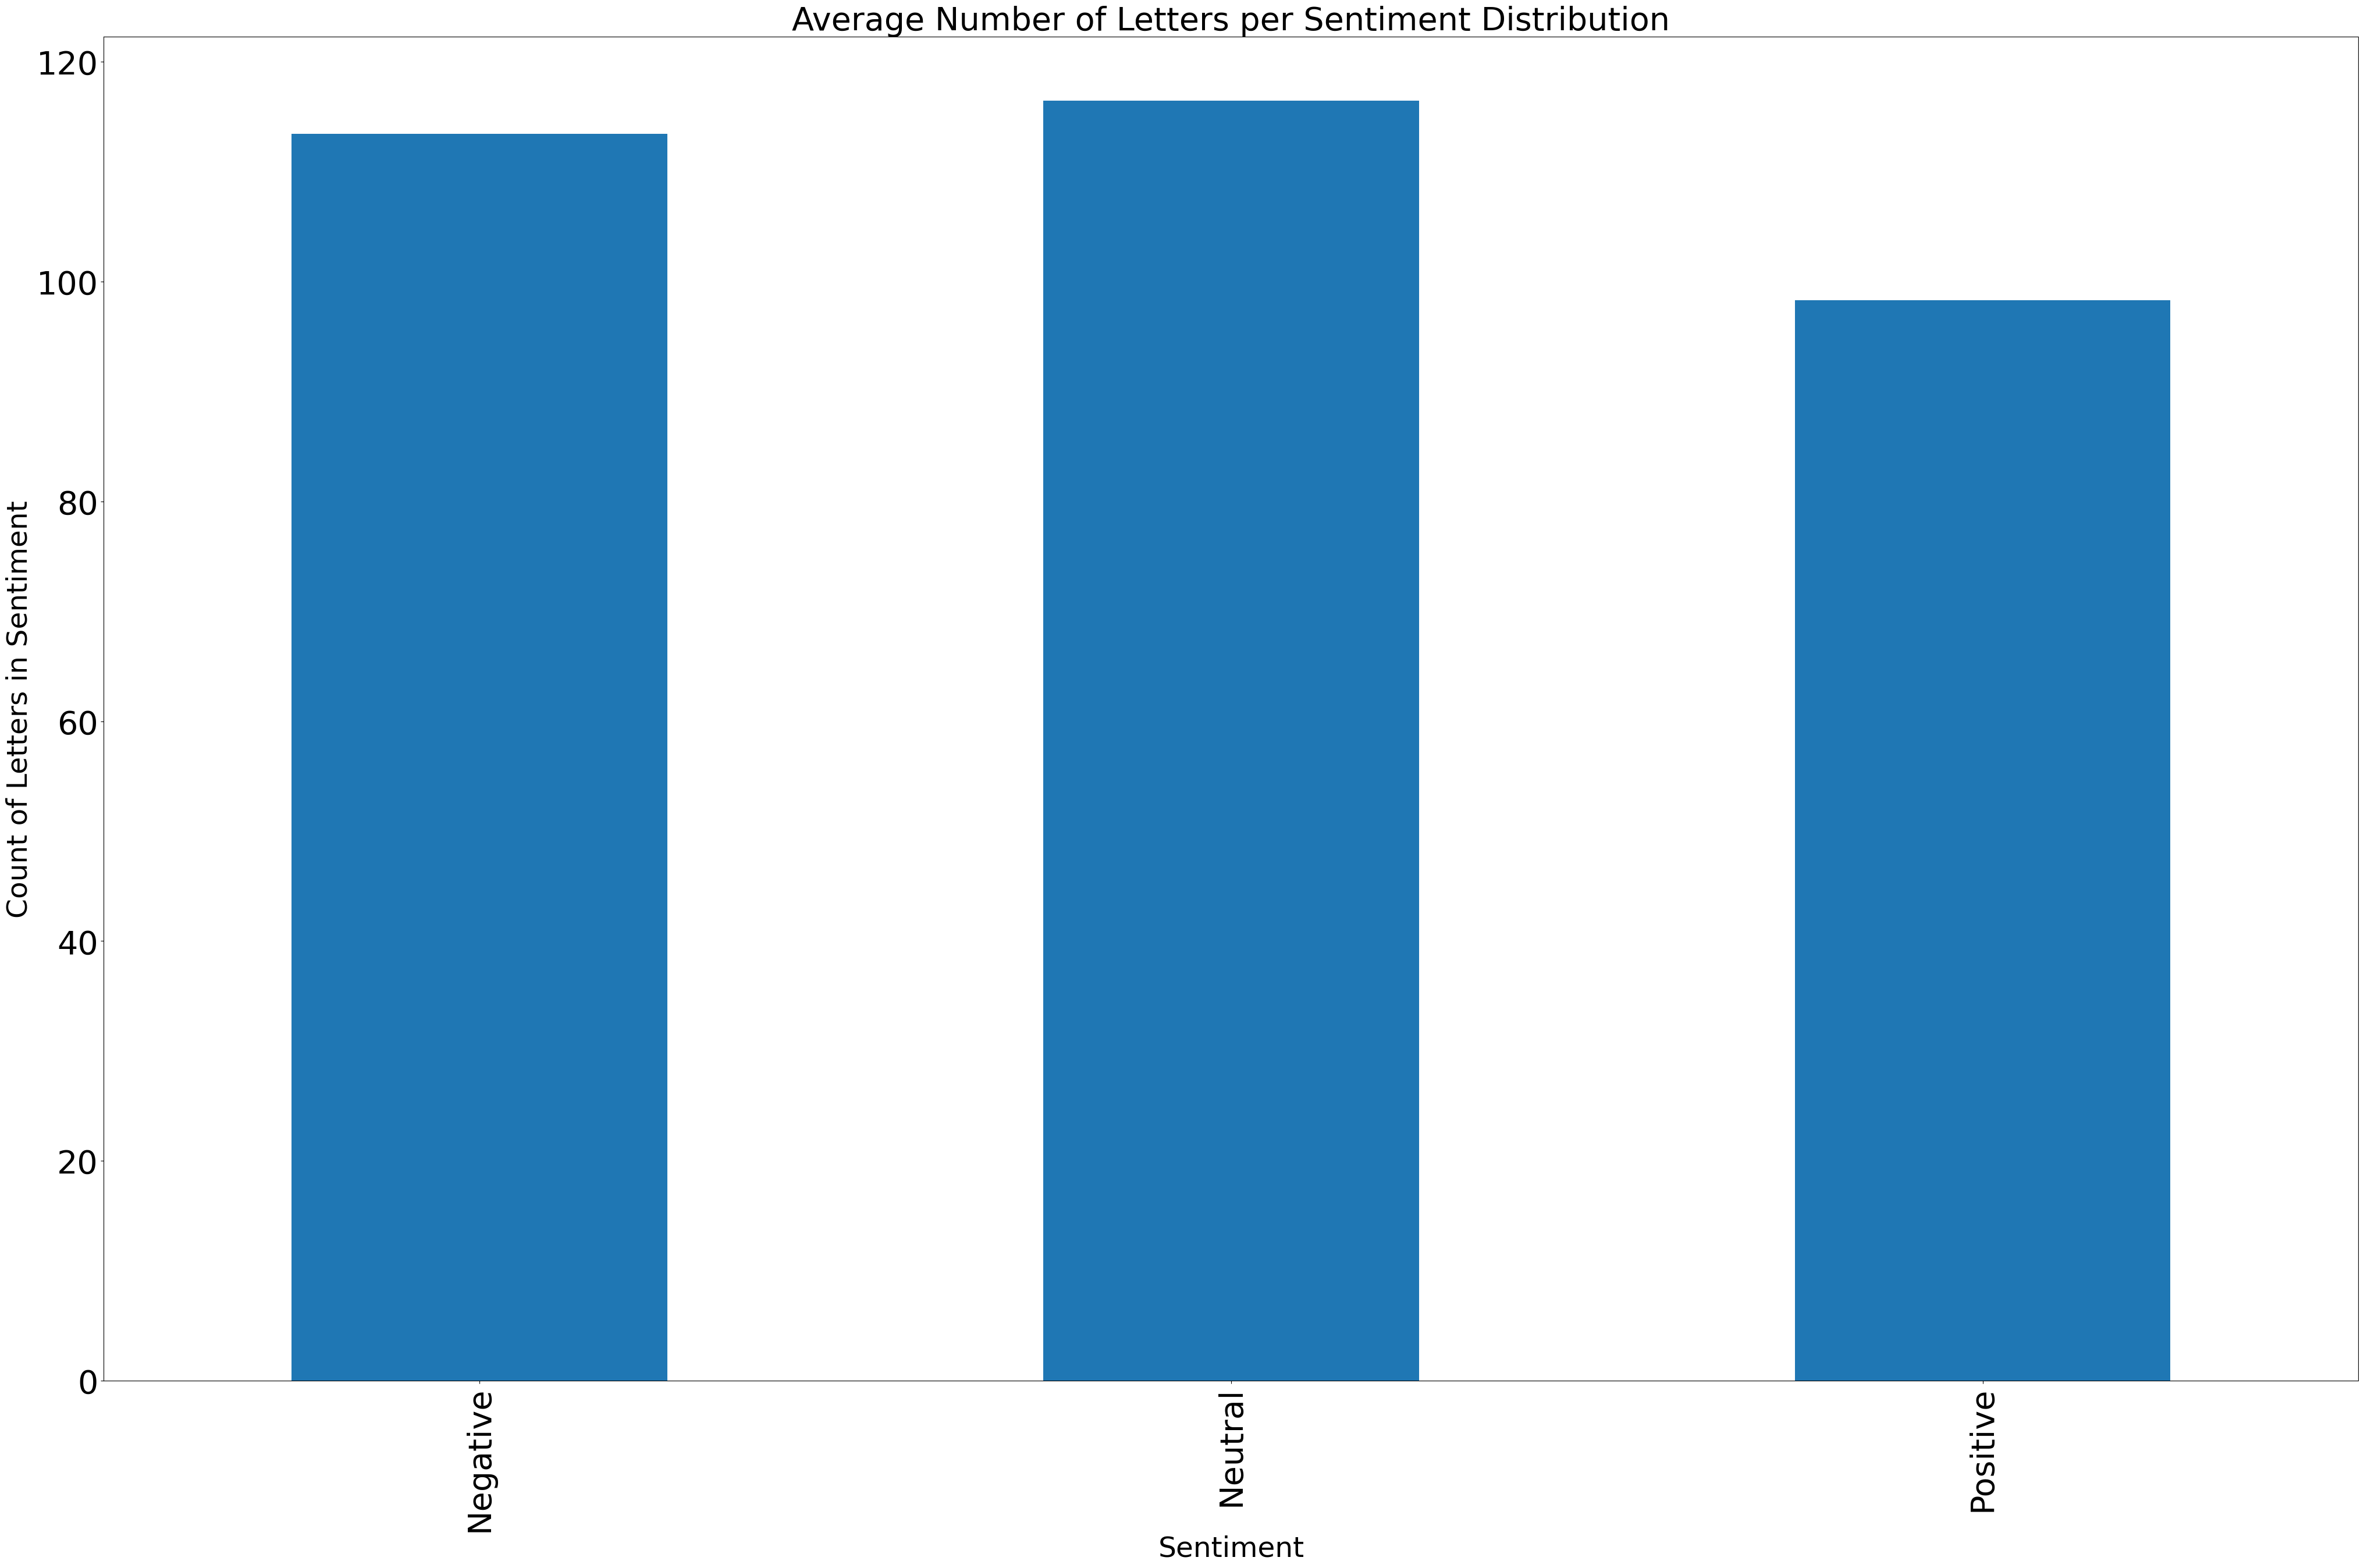

In [19]:
letter_avg = df_training.groupby('sentiment')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Sentiment', fontsize=35)
plt.ylabel('Count of Letters in Sentiment', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Sentiment Distribution', fontsize=40)
plt.show()

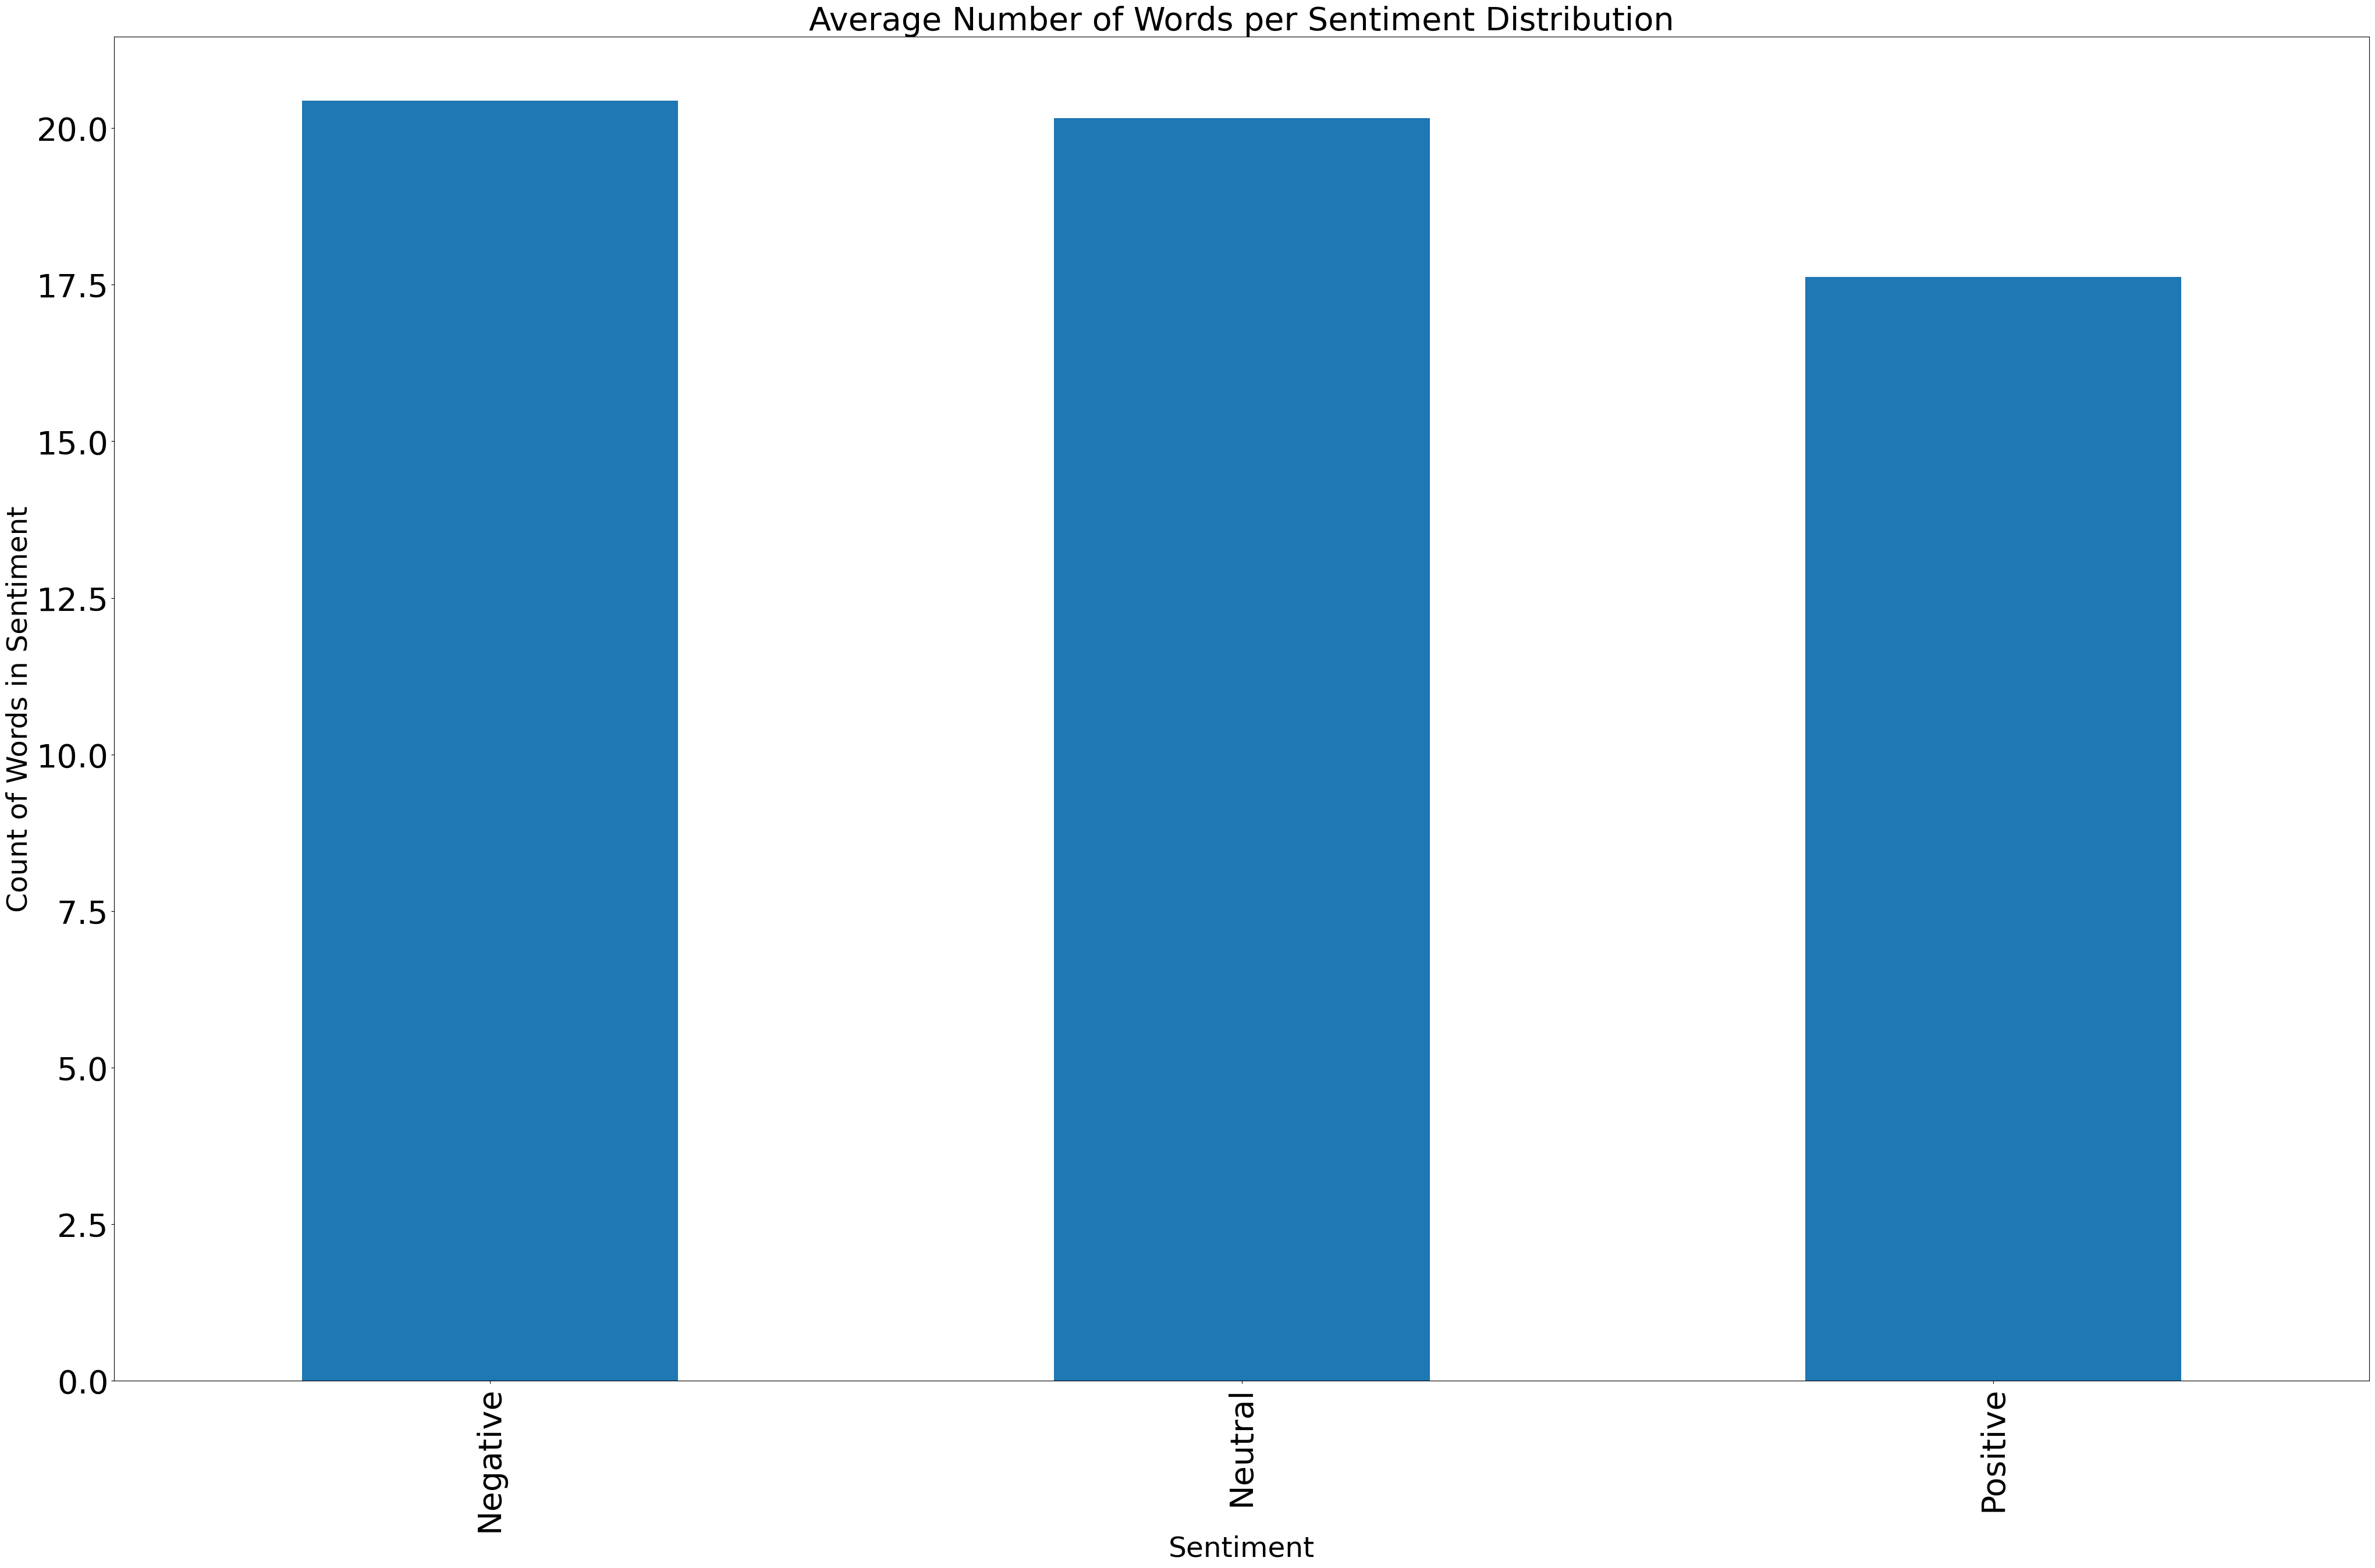

In [20]:
word_avg  = df_training.groupby('sentiment')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Sentiment', fontsize=35)
plt.ylabel('Count of Words in Sentiment', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Sentiment Distribution', fontsize=40)
plt.show()

### 3.2 Term Frequency Analysis

The word clouds below illustrates the most frequent words used for the positive, negative and neutral tweets respectively. The positive label words seem to include words such as "love", "thank" and "good". Negative words consist of majority swear words and neutral words consist of a mix of both. It can also be seen how terms such as "game", "pic" and "twitter" appear frequently in all three classes, indicating that they should be removed prior to analyysis.

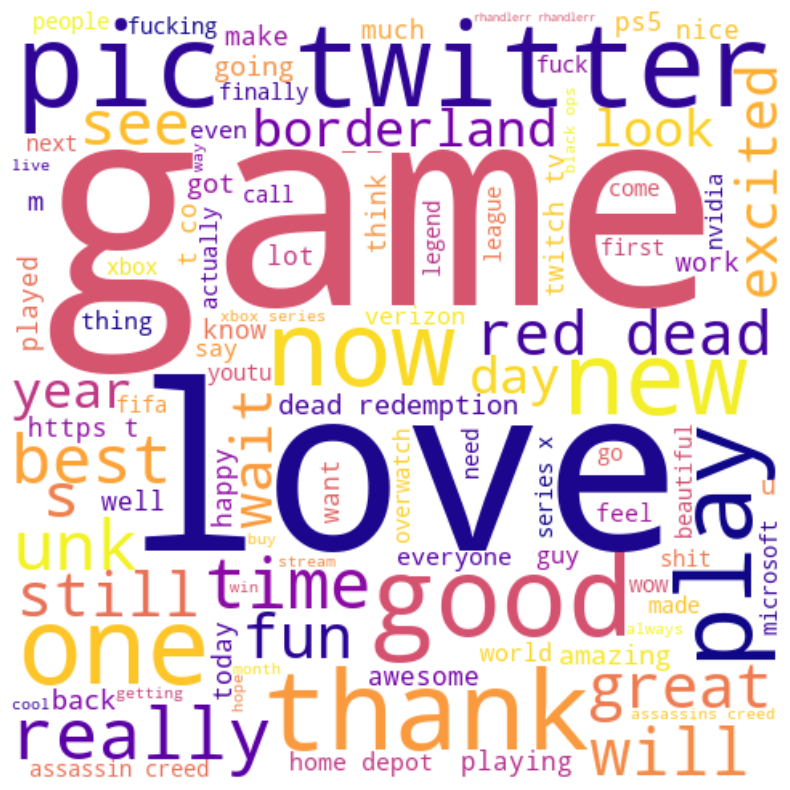

In [21]:
#Positive label words
positive_cloud = ' '.join(df_training[df_training["sentiment"] == "Positive"]["tweet"].apply(lambda x: x.lower()))

# Creation of word cloud
wordcloud = WordCloud(width=480, height=480,
    max_words=100,
    background_color="white",
     colormap="plasma"
).generate(positive_cloud)

# Figure properties
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

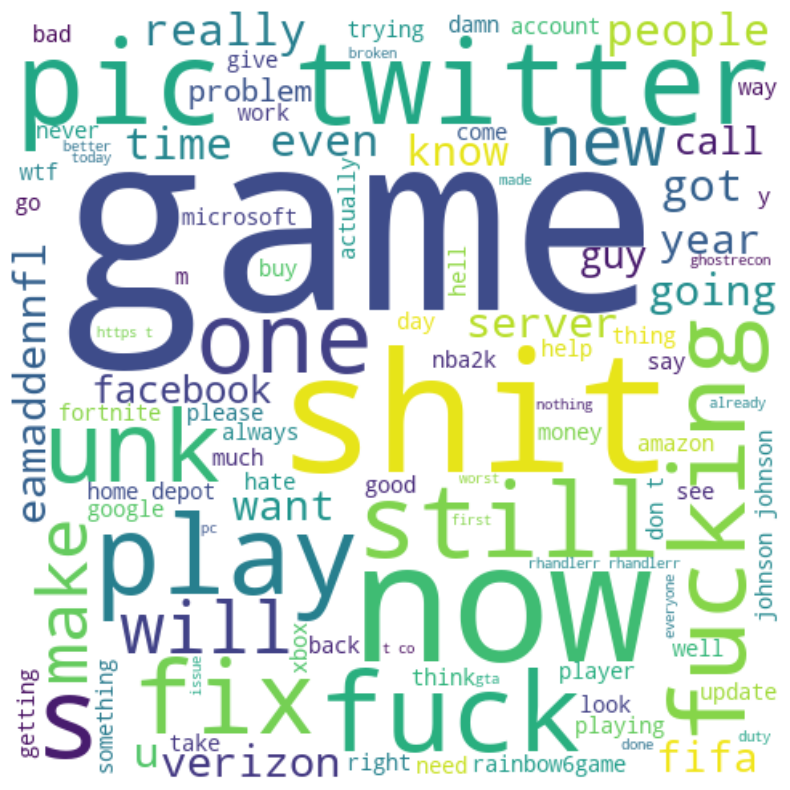

In [22]:
#Negative label words
negative_cloud = ' '.join(df_training[df_training["sentiment"] == "Negative"]["tweet"].apply(lambda x: x.lower()))

# Creation of word cloud
wordcloud = WordCloud(width=480, height=480,
    max_words=100,
    background_color="white",
     colormap="viridis"
).generate(negative_cloud)

# Figure properties
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

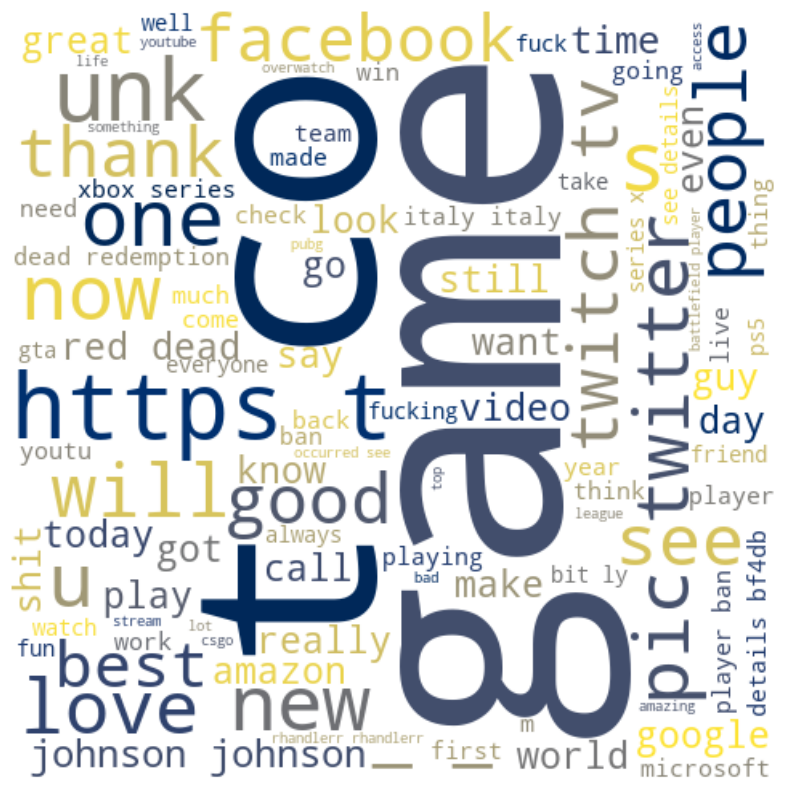

In [23]:
#Netural label words
neutral_cloud = ' '.join(df_training[df_training["sentiment"] == "Neutral"]["tweet"].apply(lambda x: x.lower()))

# Creation of word cloud
wordcloud = WordCloud(width=480, height=480,
    max_words=100,
    background_color="white",
     colormap="cividis"
).generate(neutral_cloud)

# Figure properties
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3.3 Emoji Analysis

Additionally, we can also analyse the most frequent emojis that appear for positive, neutral and negative tweets respectively. The rolling_on_the_floor_laughing emoji is the most prevalent for both positive and neutral tweets, while the person_facepalming emoji is the highest for the negative class. 

In [24]:
def split_count(text):
    emoji_list = re.findall(r'\X', text)
    emoji_list = [word for word in emoji_list if any(char in emoji.EMOJI_DATA for char in word)]
    return emoji_list

In [25]:
target_emojis = {'Positive': [],
                 'Neutral': [],
                 'Negative': []}

pattern = re.compile('\u200d')

for text, sentiment in zip(df_training["tweet"], df_training["sentiment"]):
    emoji_count = split_count(text)
    if emoji_count:
        emoji_count = [re.sub(pattern, '', e) for e in emoji_count]
        target_emojis[sentiment].extend(emoji_count)


Top emojis for Positive:
 ['🤣', '🥰', '🥺', '🤔', '🤦', '🤩', '🥳', '™', '🤯', '🤷', '🦁', '‼', '🤖', '🥴', '🤤', '🥵', '🤸', '🤞', '🦊', '🤟']


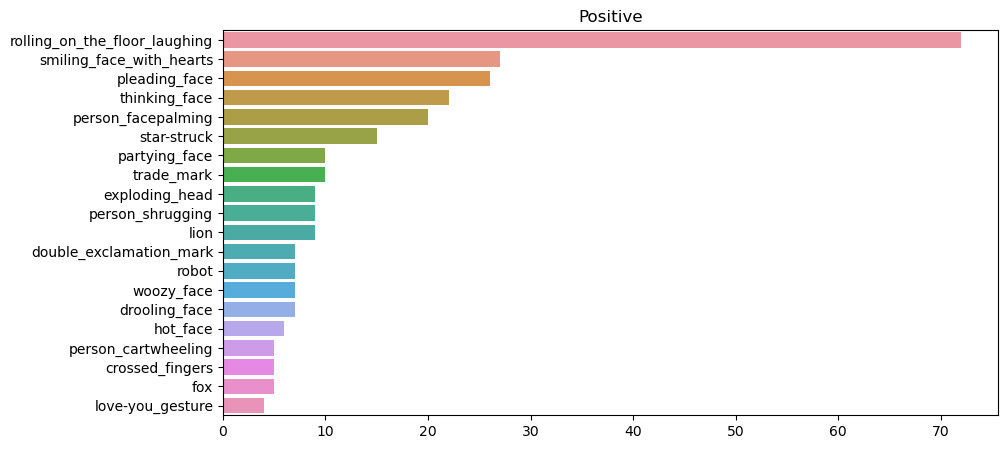


Top emojis for Neutral:
 ['🤣', '🥺', '🤦', '🤔', '🥰', '🤷', '🥳', '™', '‼', '🥴', '©', '🤗', '🤩', '🤯', '🤡', '🤬', '🤪', '🤨', '🤠', '🤓']


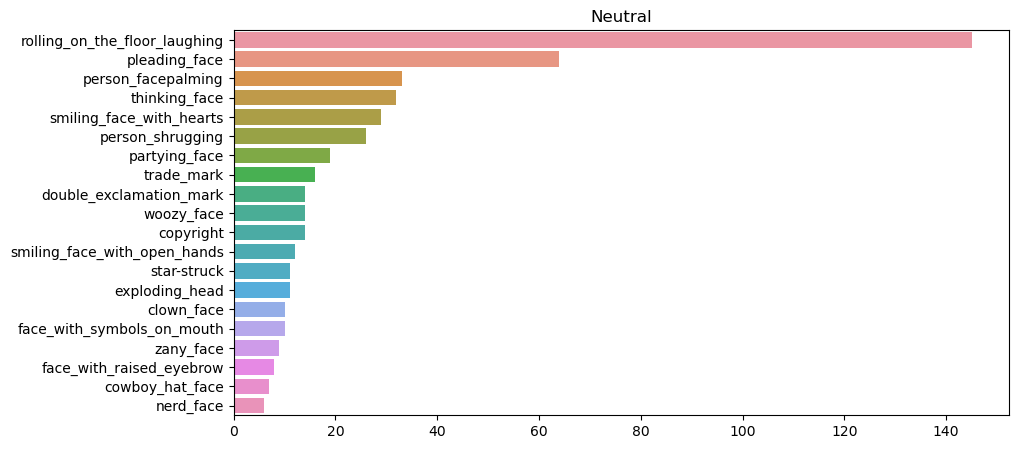


Top emojis for Negative:
 ['🤦', '🤣', '🥺', '🤬', '🥴', '🤷', '🤔', '🧢', '🤡', '🤑', '🤢', '🤩', '™', '‼', '🤪', '©', '🥰', '🤨', '🤓', '🤟']


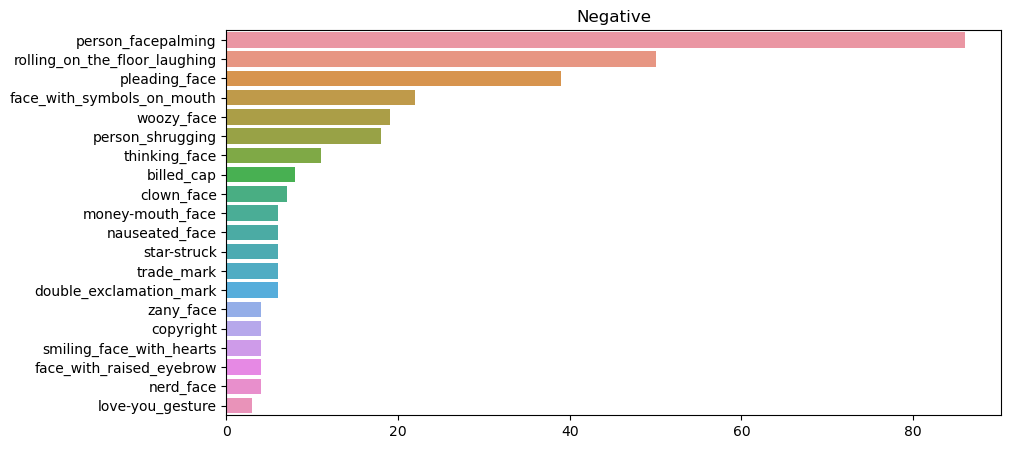

In [26]:
for t, emojis in target_emojis.items():
    plt.figure(figsize=(10, 5))
    bar_info = pd.Series(emojis).value_counts()[:20]
    print(f'\nTop emojis for {t}:\n', list(bar_info.index))
    bar_info.index = [emoji.demojize(i, delimiters=("", "")) for i in bar_info.index]
    sns.barplot(x=bar_info.values, y=bar_info.index)
    plt.title(f'{t}')
    plt.show()

### 3.4 Number of Tweets by Entity

Finally, we can check the distribution of Twitter sentiments for each of the entities in the database. We can see that certain companies like MaddenNFL and NBA2K have a majority of negative tweets while others like AssassinsCreed and Borderlands have much more positive tweets.

In [27]:
#Count information per category
counts=df_training.groupby(by=["entity","sentiment"]).size().reset_index(name = "count")
counts.head()

,entity,sentiment,count
0,Amazon,Negative,565
1,Amazon,Neutral,1382
2,Amazon,Positive,302
3,ApexLegends,Negative,574
4,ApexLegends,Neutral,1098


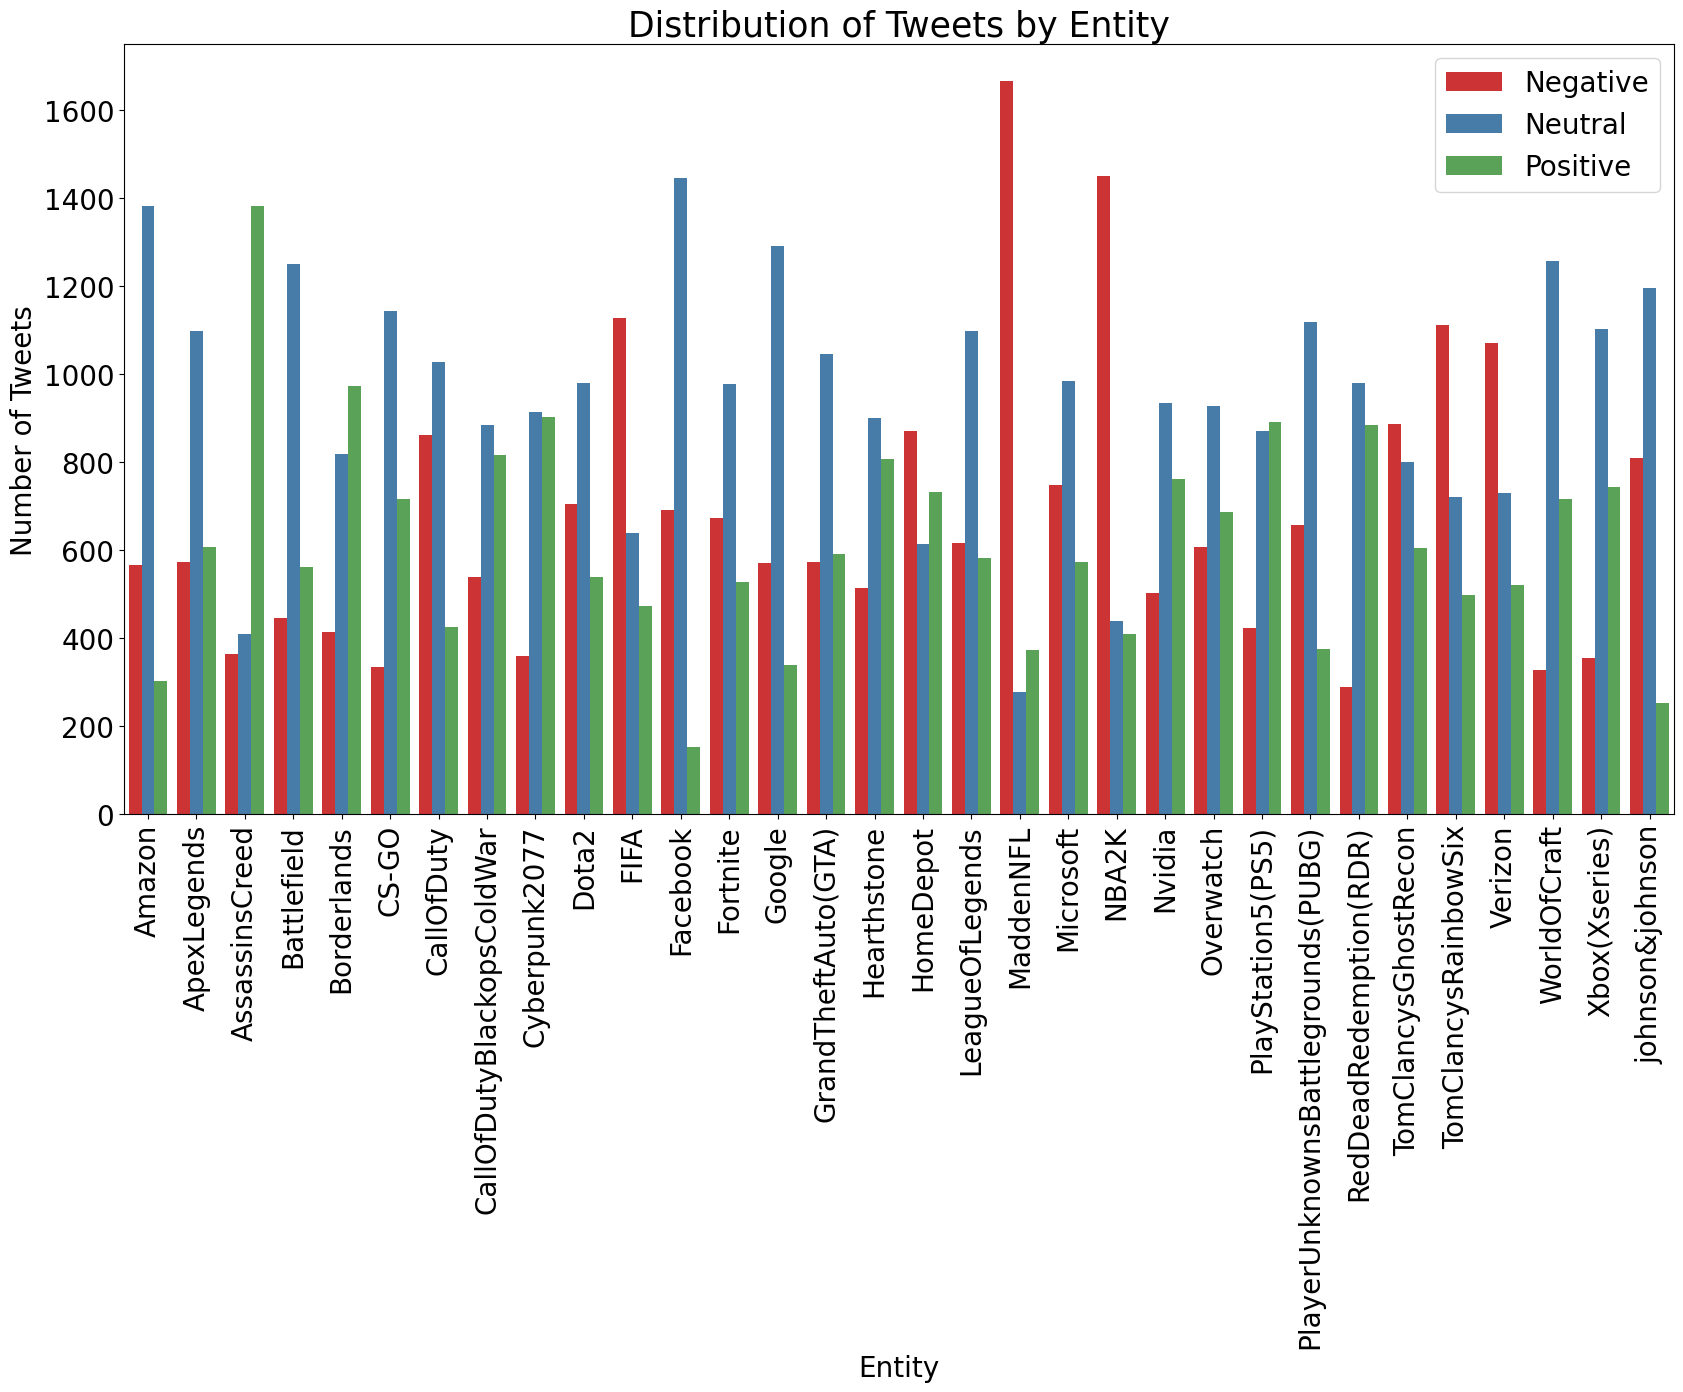

In [28]:
#Figure of comparison per branch
plt.figure(figsize=(20,10))
sns.barplot(data=counts,x="entity",y="count",hue="sentiment", palette = "Set1")
plt.xticks(rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Entity", fontsize = 20)
plt.ylabel("Number of Tweets", fontsize = 20)
plt.legend(fontsize=20)
plt.title("Distribution of Tweets by Entity", size = 25);

We can also check the distribution of tweet lengths to see how long the tweets are overall.

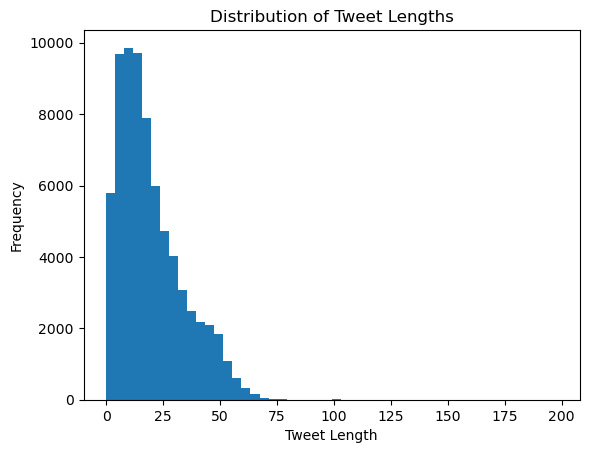

In [29]:
#Visualising the distribution of tweet lengths
tweet_lengths = [len(tweet.split()) for tweet in df_training["tweet"]]

plt.hist(tweet_lengths, bins=50)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()

## 4. Data Preprocessing <a class="anchor" id="datapreprocessing"></a>

### 4.1 Data Splitting

The input data was already split into a training and validation dataset. We will further split the training set into a 80% training set and 20% validation set.

In [30]:
#Dropping the "id" column

df_training.drop("id", axis =1, inplace = True)
df_validation.drop("id", axis =1, inplace = True)

In [31]:
#Splitting into training and testing sets

target = df_training["sentiment"]
features = df_training[["tweet", "entity"]]

X_train, X_val, y_train, y_val = train_test_split(
    features, target, test_size=0.2, random_state = 2023
)

y_test = df_validation["sentiment"]
X_test = df_validation[["tweet", "entity"]]

In [32]:
data_train = X_train
data_val = X_val
data_test = X_test

### 4.2 Text Preprocessing and Vectorization

In [33]:
#Bag of Words
vect = CountVectorizer(stop_words="english", ngram_range=(1, 1))
vect.fit(df_training["tweet"])
vocab = list(vect.get_feature_names_out())
print(len(vocab), vocab)

30764 ['00', '000', '00011', '00014', '00015', '00016', '00054', '00105', '00107', '00303', '00pm', '01', '018', '01h2y86q4', '01ueklxw9d', '02', '024', '02mwa9x1co', '03', '03573057', '0359873057', '04', '0451b', '04n0dmhdl1w', '04wcbn', '05', '0541', '057g', '06', '0604', '062', '07', '070', '07059743103', '07mtnlxijuc', '08', '080', '08038468808', '080ti', '08mmc1sxmr', '08zwcxhvqz', '09', '09808664', '0bql128yri', '0cbh6xfh5j', '0cgiah4fzl', '0ctl1mcqs7', '0cy3upa', '0dcfgx489n', '0dkyzfigdh', '0dqzvnvlzq', '0dr4hmrox5', '0ebs6ghroo', '0emqycqr32', '0espuukyhl', '0espuuukyhl', '0ezqmlg9ik', '0fhddwjh1w', '0h8oz4raj4', '0i4376xsvj', '0ieh2y86q4', '0kxwxlkxvl', '0m4hzxzlge', '0nynpnd8lw', '0pfolpsp', '0qlojg3urs', '0qmlg9ik', '0s0tgbwcw7a', '0sku6vr4ixu', '0wn3areahg', '0wn3frahg', '0wser', '0x', '0x20010004', '0x724bf428442e0e971ae5c3f924b507f0ad5ffad558bd9a6da0cb06611edfc435', '0x724bf428442e0e971ae5c3f924b507f0ad5ffad558bd9a6da0cb611ec435', '0ymqevuref', '0zv0qgxroy', '10', '100',

As can be seen in the Bag-of-Words above, there are many tokens that don't add meaning to the sentiment of the tweet. Therefore, we can perform the following preprocessing strategies to prepare the dataset for input into the models. Firstly, all words are converted into lowercase, with a count made for how many capitalized characters were removed (as typing in CapsLoc can be a signal of strong emotions). URLs, punctuation, double spaces, numbers and stopwords were removed. Emojis are decoded using the emoji.demojize method so that the computer can understand it. Finally, the words are lemmatized and vectorized using the TF-IDF vectorizer.

In [34]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.stopwords = stopwords
    
    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]
    
    def remove_double_space(self, texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stopwords] for text in tqdm(texts)]
    
    def remove_numbers(self, texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]
    
    def decode_emojis(self, texts):
        print('Decoding emojis...')
        return [emoji.demojize(text, language='en') for text in texts] 
    
    def lemmatize(self, texts):
        print('Lemmatizing...')
        lemmatized_texts = []
        for text in tqdm(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
                                    
        return lemmatized_texts
        
    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        
        if mode == 'train':
            self.train_idx = X.index
        elif mode == 'val':
            self.val_idx = X.index
        elif mode == 'test':
            self.test_idx = X.index
        print('Counting capitalized...')
        capitalized = [np.sum([t.isupper() for t in text.split()]) 
                           for text in np.array(X.values)]  # count capitalized
        # X['cap'] = capitalized
        print('Lowering...')
        X = [text.lower() for text in X]             # lower
        X = self.remove_urls(X)                      # remove urls
        X = self.remove_punctuation(X)               # remove punctuation
        X = self.remove_double_space(X)              # remove double space
        X = self.decode_emojis(X)                    # decode emojis
        X = self.remove_stopwords(X)                 # remove stopwords
        X = self.remove_numbers(X)                   # remove numbers                      
        X = self.lemmatize(X)                        # lemmatize
        
        print('Finished')
        
        return X

In [35]:
pr = Preprocessor()

#### 4.2.1 Training Dataset

In [36]:
data_train_pr = pr.transform(X_train['tweet'], mode='train')

Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|██████████| 57324/57324 [00:00<00:00, 353703.62it/s]


Removing numbers...


100%|██████████| 57324/57324 [00:00<00:00, 826194.90it/s]


Lemmatizing...


100%|██████████| 57324/57324 [03:05<00:00, 308.46it/s]

Finished


#### 4.2.2 Validation Dataset

In [37]:
data_val_pr = pr.transform(X_val['tweet'], mode='val')

Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|██████████| 14332/14332 [00:00<00:00, 348423.24it/s]


Removing numbers...


100%|██████████| 14332/14332 [00:00<00:00, 750705.77it/s]


Lemmatizing...


100%|██████████| 14332/14332 [00:45<00:00, 314.87it/s]

Finished


#### 4.2.3 Testing Dataset

In [38]:
data_test_pr = pr.transform(X_test['tweet'], mode='test')

Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|██████████| 1000/1000 [00:00<00:00, 151857.49it/s]


Removing numbers...


100%|██████████| 1000/1000 [00:00<00:00, 282997.37it/s]


Lemmatizing...


100%|██████████| 1000/1000 [00:03<00:00, 293.87it/s]

Finished


## 5. Benchmark Model <a class="anchor" id="benchmarkmodel"></a>

### 5.1 Logistic Regression

Our task is to solve a multiclass classification problem of predicting whether a tweet has a positive, negative or neutral sentiment. Logistic regression is a simple yet powerful machine learning algorithm that is a special case of linear regression. Namely, the model predicts the probability of an observation belonging to either of the three classes using a logit function. A linear regression equation is shown below, where y is the target variable and X1, X2 ... and Xn are the explanatory variables:

$$ y = \beta_0 + \beta_1X_1 + ... + \beta_{n}X_{n} $$

It does this by fitting a sigmoid curve to the observations from the training set. The curve is 'S' shaped and maps any real-valued number to a value between 0 and 1. The following equation shows the sigmoid function:

$$ \sigma(x) = {1\over 1+\exp(-y)} $$

In [39]:
# Vectorize the training data and encoding the "entity variable"
vectorizer = TfidfVectorizer(lowercase=False, max_features=8000, min_df=10, ngram_range=(1, 3), tokenizer=None)
vectorizer.fit(data_train["tweet"])

data_train_pr2 = vectorizer.transform(data_train["tweet"])
data_train_pr2 = pd.DataFrame.sparse.from_spmatrix(data_train_pr2, columns=vectorizer.get_feature_names_out())

# Retrieve feature names used during training
feature_names_train = vectorizer.get_feature_names_out()

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['entity'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

x_train2 = pd.concat([data_train_pr2, referring_ohe], axis=1)
y_train2 = y_train[y_train.index.isin(pr.train_idx)]
y_train2.index = x_train2.index

In [40]:
# Vectorize the validation data using the same feature names as training and encoding the "entity" variable
data_val_pr2 = vectorizer.transform(data_val["tweet"])
data_val_pr2 = pd.DataFrame.sparse.from_spmatrix(data_val_pr2, columns=feature_names_train)

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['entity'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = ohe.transform(data_val['entity'][data_val.index.isin(pr.val_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

x_val2 = pd.concat([data_val_pr2, referring_ohe], axis=1)
y_val2 = y_val[y_val.index.isin(pr.val_idx)]
y_val2.index = x_val2.index

In [41]:
# Vectorize the test data using the same feature names as training and encoding the "entity" variable
data_test_pr2 = vectorizer.transform(data_test["tweet"])
data_test_pr2 = pd.DataFrame.sparse.from_spmatrix(data_test_pr2, columns=feature_names_train)

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['entity'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = ohe.transform(data_test['entity'][data_test.index.isin(pr.test_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

x_test2 = pd.concat([data_test_pr2, referring_ohe], axis=1)
y_test2 = y_test[y_test.index.isin(pr.test_idx)]
y_test2.index = x_test2.index

In [42]:
# Creating a logistic regression model with RandomizedSearchCV

random_grid = {
    'C': np.arange(0.01, 1, 0.01),
    'solver': ['lbfgs', 'newton-cg', 'liblinear'],
    'max_iter': [100,200,500]
    }

random_estimator = RandomizedSearchCV(LogisticRegression(), 
                                      param_distributions = random_grid, 
                                      cv = 5,
                                      scoring = 'f1_weighted',
                                      n_jobs=-1, 
                                      verbose=2, 
                                      random_state=1
                                     )
random_estimator.fit(x_train2, y_train2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                        'max_iter': [100, 200, 500],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'liblinear']},
                   random_state=1, scoring='f1_weighted', verbose=2)

In [43]:
best_estimator_lr = random_estimator.best_estimator_

print('Best params', random_estimator.best_params_)

Best params {'solver': 'newton-cg', 'max_iter': 500, 'C': 0.9600000000000001}


In [44]:
best_estimator_lr.fit(x_train2, y_train2)
# Predict the labels for the training data

print("The training accuracy score of Logistic Regression is ", accuracy_score(best_estimator_lr.predict(x_train2), y_train2))
print("The validation accuracy score of Logistic Regression is ", accuracy_score(best_estimator_lr.predict(x_val2), y_val2))
print("The test accuracy score of Logistic Regression is ", accuracy_score(best_estimator_lr.predict(x_test2), y_test2))

The training accuracy score of Logistic Regression is  0.8136906007954783
The validation accuracy score of Logistic Regression is  0.7503488696622942
The test accuracy score of Logistic Regression is  0.861


### 5.2 Model Evaluation

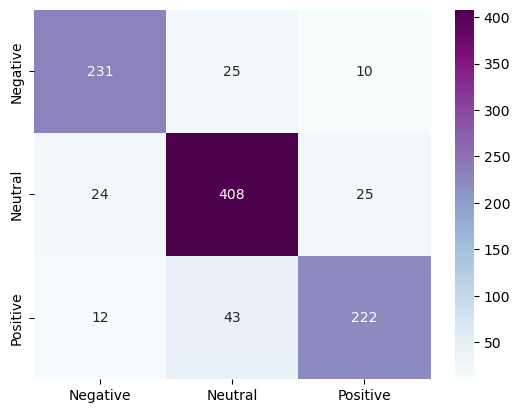

In [45]:
#Plotting a confusion matrix

classes = ['Negative', 'Neutral', 'Positive']
cm_display = sns.heatmap(confusion_matrix(y_test2, best_estimator_lr.predict(x_test2)), annot = True, fmt='g',
                        cmap = "BuPu", xticklabels=classes, yticklabels=classes)

cm_display.plot(cmap = "Blues")
plt.show()

In [46]:
y_score = best_estimator_lr.predict_proba(x_test2)

macro_roc_auc_ovr = roc_auc_score(
    y_test2,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


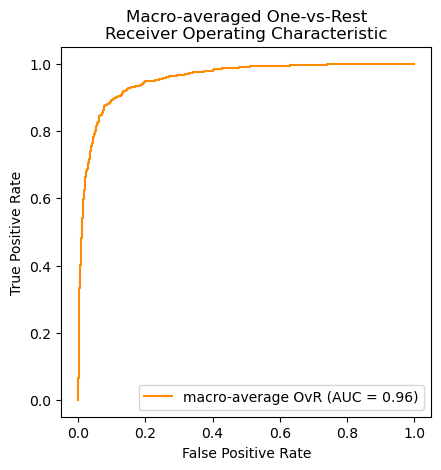

In [47]:
#Plotting the ROC Curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train2)
y_onehot_test = label_binarizer.transform(y_test2)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="macro-average OvR",
    color="darkorange"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [48]:
#Running the classification report
print(classification_report(y_test2, best_estimator_lr.predict(x_test2)))

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87       266
     Neutral       0.86      0.89      0.87       457
    Positive       0.86      0.80      0.83       277

    accuracy                           0.86      1000
   macro avg       0.86      0.85      0.86      1000
weighted avg       0.86      0.86      0.86      1000



## 6. Deep Learning Model 1: RNN <a class="anchor" id="RNN"></a>

In [49]:
max_words = 8000

tokenizer = Tokenizer(
    num_words=max_words,
    filters='"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(data_train_pr)  # Fit tokenizer on X_train

# Convert texts to sequences
x_train = tokenizer.texts_to_sequences(data_train_pr)
x_val = tokenizer.texts_to_sequences(data_val_pr)
x_test = tokenizer.texts_to_sequences(data_test_pr)

# Pad sequences
x_train = pad_sequences(x_train, maxlen=300)
x_val = pad_sequences(x_val, maxlen=300)
x_test = pad_sequences(x_test, maxlen=300)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)  # Fit label_tokenizer on y_train

# Convert labels to sequences
y_train = np.array(label_tokenizer.texts_to_sequences(y_train)) - 1
y_val = np.array(label_tokenizer.texts_to_sequences(y_val)) - 1
y_test = np.array(label_tokenizer.texts_to_sequences(y_test)) - 1

entity_train = pd.get_dummies(data_train['entity'], prefix='entity')
x_train = np.concatenate([x_train, entity_train.to_numpy()], axis=1)

entity_val = pd.get_dummies(data_val['entity'], prefix='entity')
x_val = np.concatenate([x_val, entity_val.to_numpy()], axis=1)

entity_test = pd.get_dummies(data_test['entity'], prefix='entity')
x_test = np.concatenate([x_test, entity_test.to_numpy()], axis=1)

In [50]:
x_train.shape, y_train.shape

((57324, 332), (57324, 1))

In [51]:
x_val.shape, y_val.shape

((14332, 332), (14332, 1))

In [52]:
x_test.shape, y_test.shape

((1000, 332), (1000, 1))

In [53]:
num_features = x_train.shape[1]
num_cats = 3 

def build_rnn_model(num_features, num_cats):
    random.seed(3143)

    model = Sequential([
        Embedding(8000, 128),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64),
        Dense(128, activation="relu"),
        Dropout(0.4),
        Dense(num_cats, activation="softmax")
    ])

    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

model_rnn = build_rnn_model(num_features, num_cats)

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1024000   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,053,315
Trainable params: 1,053,315
Non-

In [73]:
num_features = x_train.shape[1]
num_cats = 3

# Define the build_model function
def build_rnn_model(hp):
    random.seed(3143)

    model = Sequential()

    # Add input layer
    model.add(Embedding(8000, 128, input_length=num_features))

    # Define the hyperparameters to tune
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=3)
    num_neurons = hp.Choice('num_neurons', values=[64, 128, 256])
    activation = hp.Choice('activation', values=['relu', 'sigmoid'])
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])

    # Add hidden layers
    for _ in range(num_hidden_layers):
        model.add(SimpleRNN(num_neurons, return_sequences=True))

    # Add the last hidden layer
    model.add(SimpleRNN(num_neurons))

    # Add dense layers
    model.add(Dense(128))
    model.add(Activation(activation))
    model.add(Dropout(0.4))
    model.add(Dense(num_cats, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [74]:
# Perform hyperparameter search with Bayesian optimization
tuner = kt.BayesianOptimization(build_rnn_model, objective='val_accuracy', max_trials=10, seed=3143)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
2                 |1                 |num_layers
256               |128               |num_neurons
relu              |relu              |activation
0.01              |0.1               |learning_rate
2                 |1                 |num_hidden_layers

Epoch 1/10
   8/1792 [..............................] - ETA: 6:19 - loss: 3.0704 - accuracy: 0.3789

KeyboardInterrupt: 

In [75]:
tuner.results_summary(1)

Results summary
Results in .\untitled_project
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
num_layers: 1
num_neurons: 128
activation: relu
learning_rate: 0.1
num_hidden_layers: 1
Score: 0.4569999873638153


In [63]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters)

# Evaluate the best model
best_model.evaluate(x_test, y_test)

Best Hyperparameters:
32/32 [==============================] - 2s 40ms/step - loss: 1.0821 - accuracy: 0.4570


[1.0820775032043457, 0.4569999873638153]

In [64]:
model_rnn = build_rnn_model(best_hyperparameters)
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 332, 128)          1024000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 332, 128)          32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [82]:
plot_model(model_rnn)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [80]:
conda install graphviz

^C


In [69]:
from ann_visualizer.visualize import ann_viz;

ann_viz(model_rnn, title="Recurrent Neural Network")

ValueError: ANN Visualizer: Layer not supported for visualizing

In [68]:
plot_model(model_rnn, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
#Implementing early stopping
#es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", verbose=2)
#%time hist = model_rnn.fit(x_train, y_train, epochs=10, \
                           callbacks=[es], validation_data=(x_test, y_test), verbose=0)

In [ ]:
#Compiling and fitting the RNN model 
model_rnn.compile("adam",
              "sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_rnn = model_rnn.fit(x_train,
                    y_train,
                    validation_data=(x_test,y_test),
                    epochs=5,
                    batch_size = 512)

In [ ]:
model_rnn.evaluate(x_train, y_train, verbose=1)

In [ ]:
model_rnn.evaluate(x_val, y_val, verbose=1)

In [ ]:
model_rnn.evaluate(x_test, y_test, verbose=1)

In [ ]:
#Plotting the training and validation loss curves
plt.figure(1)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Plotting a confusion matrix

y_pred_prob_rnn = model_rnn.predict(x_test)
y_pred_rnn = np.argmax(y_pred_prob_rnn, axis=1)

# Convert y_test to class labels if it's in one-hot encoded format
y_test_labels_rnn = np.argmax(y_test, axis=1)


classes = ['Negative', 'Neutral', 'Positive']
cm_display = sns.heatmap(confusion_matrix(y_test, y_pred_rnn), annot = True, fmt='g',
                        cmap = "YlGnBu", xticklabels=classes, yticklabels=classes)

cm_display.plot(cmap = "Blues")
plt.show()

## 7. Deep Learning Model 2: LSTM <a class="anchor" id="LSTM"></a>

In [ ]:
num_features = x_train.shape[1]
num_cats = 3 
max_words = 8000
output_dim=128
input_len = 300
max_length = 100  #Chosen from histogram above


def build_lstm_model(num_features, num_cats):
    random.seed(3143)

    model = Sequential([
        Embedding(input_dim=max_words, output_dim=output_dim, input_length=input_len),
        SpatialDropout1D(0.3),
        LSTM(128, dropout=0.3, recurrent_dropout=0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(num_cats, activation="softmax")
    ])

    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

model_lstm = build_lstm_model(num_features, num_cats)

model_lstm.summary()

In [ ]:
#es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", verbose=2)
#%time hist = model_lstm.fit(x_train, y_train, epochs=10, callbacks=[es], validation_data=(x_test, y_test), verbose=2)

In [59]:
num_features = x_train.shape[1]
num_cats = 3 
max_words = 8000
output_dim=128
input_len = 332
max_length = 100  #Chosen from histogram above

#Hyperparameter tuning

def build_lstm_model(hp):
    model = Sequential()
    
    # Define the hyperparameters to tune
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    num_neurons = hp.Choice('num_neurons', values=[64, 128, 256])
    activation = hp.Choice('activation', values=['relu', 'sigmoid'])
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
    
    model.add(Embedding(input_dim=max_words, output_dim=num_neurons, input_length=input_len))
    model.add(SpatialDropout1D(0.3))
    
    for _ in range(num_layers):
        model.add(LSTM(units=num_neurons, dropout=0.3, recurrent_dropout=0.3))
    
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(num_cats, activation="softmax"))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Use Keras Tuner's BayesianOptimization tuner
tuner = kt.BayesianOptimization(build_lstm_model, objective='val_accuracy', max_trials=10, seed=3143)

# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
128               |128               |num_neurons
relu              |relu              |activation
0.1               |0.1               |learning_rate

Epoch 1/10
  66/1792 [>.............................] - ETA: 13:11 - loss: 2.1918 - accuracy: 0.4143

KeyboardInterrupt: 

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters)

# Evaluate the best model
best_model.evaluate(x_test, y_test)

In [ ]:
# Get the best parameters from grid search
tuner.results_summary(1)

# Build the model with the best parameters
model_lstm = build_lstm_model(best_hyperparameters)
model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test) , 
    epochs = 5,
    batch_size = 512
)

In [ ]:
model_lstm.evaluate(x_train, y_train, verbose=1)

In [ ]:
model_lstm.evaluate(x_val, y_val, verbose=1)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

In [ ]:
plt.figure(1)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Plotting a confusion matrix

y_pred_prob_lstm = model_lstm.predict(x_test)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

# Convert y_test to class labels if it's in one-hot encoded format
y_test_labels_lstm = np.argmax(y_test, axis=1)


classes = ['Negative', 'Neutral', 'Positive']
cm_display = sns.heatmap(confusion_matrix(y_test, y_pred_lstm), annot = True, fmt='g',
                        cmap = "YlGnBu", xticklabels=classes, yticklabels=classes)

cm_display.plot(cmap = "Blues")
plt.show()

## 8. Discussion <a class="anchor" id="discussion"></a>